# Approximators for low-thrust transfers

Before computing a full low-thrust transfer is often convenent to compute approximations that are computationally less heavy and help anyway to establish the worth of a given transfer opportunity. The main purpose of these is to avoid computing eventually the low-thrust transfer altogether, and thus prune out uninteresting cases.

In the old-school one would use Edelbaum, Lambert as well as Hohmann $\Delta V$ and transfer times $T$ as to produce quick estimates for these quantities, maybe incomprating some gravity loss coefficident set to an arbitrary value (argauble learned from experience). In the last decade, also thanks to the many [GTOC competitions](https://sophia.estec.esa.int/gtoc_portal/) new concpets and approximations have been developed that are much more informative and precise. In *pykep* we implemented a few, mainly from our own work and developments and that have since been embraced by the larger trajectory design community.

In this notebook we give some examples of their usage.

In [1]:
import pykep as pk 
import numpy as np 
import heyoka as hy

import pygmo as pg
import pygmo_plugins_nonfree as ppnf

In order to access a large number of possible targets (asteroids) we use the GTOC12 dataset which we read and use to produce a list of {class}`~pykep.planet`. We add the Earth in Keplerian motion as a {class}`~pykep.planet` at index azero so that we also obtain the nice property of indexing the asteroid with their id directly.

In [2]:
# This epoch is used to define all asteroid in the GTOC 12 dataset.
when = pk.epoch(64328, pk.core.epoch.julian_type.MJD)
# We read in the file
raw_data = np.loadtxt("GTOC12_Asteroids_Data.txt", skiprows=1)[:,2:]
raw_data[:,2:]*=pk.DEG2RAD
raw_data[:,0]*=pk.AU

In [3]:
# And create the planets
earth = pk.planet(pk.udpla.keplerian(pk.epoch(64328, pk.epoch.julian_type.MJD),
                            (1.49579151285E8*1000, 1.65519129162E-2, 4.64389155500E-3 * pk.DEG2RAD,
                             1.98956406477e2 * pk.DEG2RAD, 2.62960364700e2 * pk.DEG2RAD, 3.58039899470e2 * pk.DEG2RAD),
                            pk.MU_SUN,
                            "earth", el_type=pk.el_type.KEP_M))

gtoc12_asts = [earth]
for i, elements in enumerate(raw_data):
    gtoc12_asts.append(pk.planet(pk.udpla.keplerian(when, elements, pk.MU_SUN, "gtoc12 ast-"+str(i+1), el_type=pk.el_type.KEP_M)))

Let us visualize on the fly a *snapshot* at the chosen epoch of this population of asteroids. We also ovelray the Earth orbit to give a sense of dimensions and we only plot 1/10 asteroids as to
speed up the plot creation.

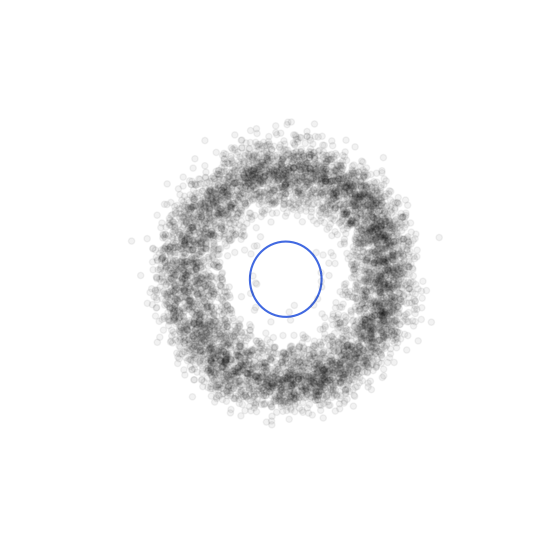

In [4]:
# Using built-in pykep plotting routines
ax3D = pk.plot.make_3Daxis(figsize=(7,7))
pk.plot.add_planets(ax3D, gtoc12_asts[::10], when =when, units=pk.AU, c='black', alpha=0.05)
pk.plot.add_planet_orbit(ax3D, pk.planet(pk.udpla.jpl_lp("earth")), units=pk.AU, c="royalblue")
ax3D.view_init(elev=90, azim=0)
ax3D.set_axis_off()

## The Orbital Metric

Consider now the problem of selecting what transfer some spacecarft could make when sitting at some asteroid (say id = 24) at epoch $t_0$. To answer the question we could:

* Solve all low-thrust transfers to all possible targets (ehm, ... well sure going to take some time, what if we then need to change the id or $t_0$ and need to do this multiple times?). This option is rather slow and still leaves open the question on whether to look for time optimal or mass optimal transfers. 

* Fix some time of flight $T$ and solve all Lambert transfers to all targets. Consider the resulting $\Delta V$ as a ranking of good transfer options. (This option is actually not bad, but is very sensitive to the chosen $T$, requires to solve a lot of Lambert Problems and is not a metric: thus it does not possess a number of nice and useful properties)

* Define a concept of metric between orbiting objects, one that acconts for physical proximity (in the phase space) as well as directionality, and use that to find neighbours and clusters. 

In the work {cite:p}`izzo2016designing` the concept of the *orbital metric* is introduced , which is a metric in the phase space of the two-body problem that is able to capture the physical proximity of two objects, including phasing.

In [5]:
# We check what asteroids are close to each other at epoch mjd2000 = 5500 under the orbital metric
when = pk.epoch(5500)
tof_days = 200
knn_instance = pk.knn(gtoc12_asts, when, tof=tof_days, metric='orbital')
# And find the closest 5 neighbours to the asteroid with id=24
ast_id_ref = 24
neighbours_names, neighbours_idxs, neighbours_dists = knn_instance.find_neighbours(ast_id_ref, k = 10)

... and visualize the selected asteroids.

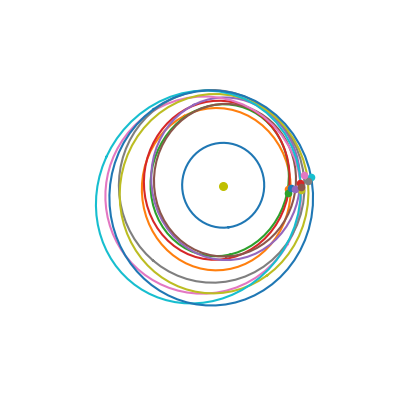

In [6]:
ax = pk.plot.make_3Daxis(figsize=(5,5))
pk.plot.add_sun(ax)
pk.plot.add_planet_orbit(ax, earth)
for id in neighbours_idxs:
    pk.plot.add_planet_orbit(ax, gtoc12_asts[id])
    pk.plot.add_planet(ax, gtoc12_asts[id], when)
ax.view_init(90,90)
ax.axis('off');

Clearly the neighbours found are approximately well phased asteroids that can be considered for a transfer (a hop). The above computation is extremely quick to make, so that for the asteroids found we can afford to complexify our trajectory model. For example computing now the transfer Maximum initial mass approximations (which are also computationally light as they require only Lambert arc computations)

We measure the computational cost of running the orbital metric:

:::{note}
This cost covers the computation of the orbital metric for all pairs of asteroids (having fixed the epoch), and is the most expensive part of the computation. The cost of the performing further queries (i.e. for different asteroid ids) is negligible in comparison.

In [7]:
%%timeit
knn_instance = pk.knn(gtoc12_asts, when, tof=tof_days, metric='orbital')
neighbours_names, neighbours_idxs, neighbours_dists = knn_instance.find_neighbours(ast_id_ref, k = 10)

208 ms ± 3.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## The Maximum Initial Mass Approximations - MIMA(s)

In [8]:
Tmax = 0.6
Isp = 4000

r,v = gtoc12_asts[ast_id_ref].eph(when)
for idx in neighbours_idxs[1:]:
    posvel_f = gtoc12_asts[idx].eph(when + tof_days)
    l = pk.lambert_problem(r, posvel_f[0], tof = tof_days*pk.DAY2SEC, mu=pk.MU_SUN)
    dv1 = [a-b for a,b in zip(l.v0[0],v)]
    dv2 = [a-b for a,b in zip(posvel_f[1], l.v1[0])]
    mima = pk.mima(dv1, dv2, tof_days*pk.DAY2SEC, Tmax=Tmax, veff = pk.G0 * Isp)[0]
    posvel = [r, l.v0[0]]
    mima2 = pk.mima2(posvel, dv1, dv2, tof_days*pk.DAY2SEC, Tmax=Tmax, veff = pk.G0 * Isp, mu = pk.MU_SUN)[0]
    lambert_dv = np.linalg.norm(dv1) + np.linalg.norm(dv2)
    lambertm = Tmax / (lambert_dv / (tof_days*pk.DAY2SEC))
    print(f"idx: {idx}: mima: {mima:.8f}, mima2: {mima2:.8f}, lambert_estimate: {lambertm:.8f}")


idx: 56806: mima: 1270.16102850, mima2: 1336.53752329, lambert_estimate: 1980.95464032
idx: 21298: mima: 1376.28433396, mima2: 1349.12057368, lambert_estimate: 2365.34798345
idx: 11241: mima: 805.84627823, mima2: 764.22499061, lambert_estimate: 1413.08850455
idx: 17333: mima: 966.96031125, mima2: 942.28767024, lambert_estimate: 1720.34149613
idx: 58382: mima: 899.57118064, mima2: 981.70709084, lambert_estimate: 1196.73301555
idx: 9791: mima: 952.07569132, mima2: 939.52952745, lambert_estimate: 1490.11499765
idx: 59398: mima: 868.63412492, mima2: 849.81378715, lambert_estimate: 1446.03050794
idx: 13156: mima: 892.72968973, mima2: 899.41910901, lambert_estimate: 1491.10483402
idx: 55344: mima: 838.49574444, mima2: 808.47917624, lambert_estimate: 1322.65465481


Theres a very good correlation between the ranking assembled by the orbital metric and that of the MIMA(s). The Lambert based approximation has a much larger error, whch can be reduced introducing an arbitrary gravity loss coefficient, but still the MIMA(s) are much more informative and precise.

:::{note}
The ranking produced by the various criteria is sensitive to the value set for the time of flight.

We profile the computational cost of the MIMA(s) computation (this referes to one only asteroid id.)

In [9]:
%%timeit
mima = pk.mima(dv1, dv2, tof_days*pk.DAY2SEC, Tmax=Tmax, veff = pk.G0 * Isp)[0]


988 ns ± 8.36 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [10]:
%%timeit
mima2 = pk.mima2(posvel, dv1, dv2, tof_days*pk.DAY2SEC, Tmax=Tmax, veff = pk.G0 * Isp, mu = pk.MU_SUN)[0]


217 μs ± 161 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


The cos of running MIMA for one asteroid is equivalent to the cost of running the orbital metric on all asteroid couples!

In order to have a clear picture on the error introduced by using the aproximations above, we can actually compute (spendin more resources) the ground truth, the actual MIM.

In [11]:
for idx in neighbours_idxs[1:]:
    mim = pk.trajopt.mim_from_hop(gtoc12_asts[24], gtoc12_asts[idx], when, when + 200, 0.6, 4000*pk.G0)
    print(f"idx: {idx}: mim: {mim:.8f}")



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

idx: 56806: mim: 1305.48262436
idx: 21298: mim: 1324.55552640
idx: 11241: mim: 734.44276855
idx: 17333: mim: 918.53331068
idx: 58382: mim: 1042.69835142
idx: 9791: mim: 969.96360092
idx: 59398: mim: 851.56538339
idx: 13156: mim: 888.98946946
idx: 55344: mim: 815.63364437


And the corresponding cost being order of magnitude larger.

In [12]:
%%timeit
mim = pk.trajopt.mim_from_hop(gtoc12_asts[24], gtoc12_asts[idx], when, when + 200, 0.6, 4000*pk.G0)

221 ms ± 25.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## The minimum transfer time (not approximated)
Another important information to help select the target for a low-thrust transfer is the minimum transfer time (assuming an initial mass). This can be computed exactly at the cose of some CPU time, but it helps to understand the worth of using some approximate method before emmploying it in a large scale computation. 

In [13]:
# Factory for the pygmo problem.
def prob_factory(ast_id_s, ast_id_t, T_max, tof_guess, when):
    udp = pk.trajopt.pontryagin_cartesian_time(
        source= gtoc12_asts[ast_id_s],
        target= gtoc12_asts[ast_id_t],
        tof_guess=tof_guess,
        t0 = when,
        T_max=T_max,
        Isp=3000,
        m0=1500,
        L=pk.AU,
        TIME=pk.YEAR2DAY * pk.DAY2SEC,
        MASS=1500,
        with_gradient=True,
    )
    prob = pg.problem(udp)
    prob.c_tol = 1e-6
    return prob

# Factory for the pygmo algorithm.
def algo_factory(max_iter):
    ip = pg.ipopt()
    ip.set_integer_option("max_iter", max_iter)  # Change the maximum iterations
    ip.set_integer_option("print_level", 0)  # Makes Ipopt unverbose
    ip.set_string_option(
        "nlp_scaling_method", "none"
    )  # Removes any scaling made in auto mode
    ip.set_string_option(
        "mu_strategy", "adaptive"
    )  # Alternative is to tune the initial mu value
    return pg.algorithm(ip)

In [14]:
masses = []
times = []
xs = []
for idx_t in neighbours_idxs[1:]:
    prob = prob_factory(24, idx_t, 0.6, 250, when)
    algo = algo_factory(100)
    udp = prob.extract(pk.trajopt.pontryagin_cartesian_time)
    for i in range(100):
        pop = pg.population(prob, 1)
        pop = algo.evolve(pop)
        if prob.feasibility_f(pop.champion_f):
            udp.fitness(pop.champion_x)
            masses.append(udp.ta.state[6])
            times.append(pop.champion_x[-1]*udp.TIME*pk.SEC2DAY)
            break
        else:
            print("x", end="")
    print(f"idx: {idx_t}: minumum time: {times[-1]:.2f}, mass: {masses[-1]*udp.MASS:.2f}")


idx: 56806: minumum time: 228.61, mass: 1097.18
idx: 21298: minumum time: 219.98, mass: 1112.37
xidx: 11241: minumum time: 355.47, mass: 873.63
idx: 17333: minumum time: 285.46, mass: 997.00
idx: 58382: minumum time: 236.69, mass: 1082.94
idx: 9791: minumum time: 247.80, mass: 1063.37
idx: 59398: minumum time: 276.69, mass: 1012.46
idx: 13156: minumum time: 282.90, mass: 1001.51
xidx: 55344: minumum time: 292.73, mass: 984.18
